# **Genotype_Phenotype_CNN Project**

## **Importing important Libraries**

In [2]:
%matplotlib inline
%load_ext tensorboard
#!pip install keras-tuner
import pandas as pd
import numpy as np
import tensorflow as tf
for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)
from matplotlib import pyplot as plt
import keras_tuner as kt
from sklearn.metrics import confusion_matrix, accuracy_score

2023-05-03 21:47:56.201247: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 21:47:56.298509: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-03 21:47:56.839798: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/rkannan/miniconda3/envs/richard_tf/lib/
2023-05-03 21:47:56.839858: W tensorflow

## **Loading Datasets **

In [4]:
genotypeFile = 'genotype.csv'
genotype = pd.read_csv(genotypeFile, sep = '\t', index_col = 0)
print('genotypeFile shape:', genotype.shape )

phenotypeFile = 'phenotype.csv'
multi_pheno = pd.read_csv(phenotypeFile, sep = ',', index_col = 0)
print('Phenotype_Multi shape:', multi_pheno.shape )


# take a small part to test code
# genotype
X = genotype
# X = genotype.iloc[0:1000:, 0:5000]
# single_pheno
Y = multi_pheno.iloc[:, 5]#index=2 --> 1_E6-Berbamine_1
# Y = multi_pheno.iloc[0:1000, pheno_i]


# # Add noise
# random missing masker
missing_perc = 0.1
nonmissing_ones = np.random.binomial(
    1, 1 - missing_perc, size=X.shape[0] * X.shape[1])
nonmissing_ones = nonmissing_ones.reshape(X.shape[0], X.shape[1])
nonmissing_ones, nonmissing_ones.shape

corrupted_X = X * nonmissing_ones
# corrupted_X.head()

# # Prepare data
# ## One-hot encoding

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
#X_onehot = to_categorical(X)
corrupted_X_onehot = to_categorical(corrupted_X)
# corrupted_X_onehot.shape

# normlization
scaled_Y = (Y - Y.min()) / (Y.max() - Y.min())


def detect_outliers(df):
    outlier_indices = []

    Q1 = np.percentile(df, 25)
    Q3 = np.percentile(df, 75)
    IQR = Q3 - Q1
    outlier_step = 1.5 * IQR

    outlier_indices = df[(df < Q1 - outlier_step) |
                         (df > Q3 + outlier_step)].index

    return outlier_indices


temp_Y = scaled_Y[~scaled_Y.isna()]
outliers_index = detect_outliers(temp_Y)


# set outliers as NAN
scaled_Y_ = scaled_Y.copy()
scaled_Y_[outliers_index] = np.nan


# ## Split train and test
train_X, test_X, corrupted_train_X, corrupted_test_X, train_Y, test_Y = train_test_split(
    X, corrupted_X_onehot, scaled_Y_.iloc[:], test_size=0.1)

# split df to train and valid
train_X, valid_X, corrupted_train_X, corrupted_valid_X, train_Y, valid_Y = train_test_split(
    train_X, corrupted_train_X, train_Y, test_size=0.1)



x_train = to_categorical(pd.concat([train_X,train_Y],axis=1).dropna().iloc[:,0:-1])
y_train = train_Y.dropna().to_numpy()

x_valid = to_categorical(pd.concat([valid_X,valid_Y],axis=1).dropna().iloc[:,0:-1])
y_valid = valid_Y.dropna().to_numpy()

x_test = to_categorical(pd.concat([test_X,test_Y],axis=1).dropna().iloc[:,0:-1])
y_test  = test_Y.dropna().to_numpy()

genotypeFile shape: (4390, 28220)
Phenotype_Multi shape: (4390, 20)


## **PART 2 - BUILDING THE Model**

### Initializing the CNN and Building the layers

In [3]:
def model_build(pheno_name,num_hl,hl_list,hl_activation, out_activation, dropout_val,filters_, kernel_size_,stride_poolSize,Conv_Layers_Stride_Size):
    

    '''
    https://towardsdatascience.com/multi-output-model-with-tensorflow-keras-functional-api-875dd89aa7c6

    def DNN_build(num_hl,hl_list,hl_activation, out_activation, dropout_val):
    pheno_name = name of phenotype of interest
    num_hl = number of hidden layers
    hl_list = list of hidden layers
    hl_activation = hidden layer activation function
    out_activation = output layer activation function
    dropout_val = Dropout value
    '''
    assert(num_hl == len(hl_list))
    assert(num_hl == len(dropout_val))
    input_layer = tf.keras.Input(shape=(28220, 3))#(3138, 28220, 3)
    
    shared_convL1 = tf.keras.layers.Conv1D(filters = filters_,kernel_size = kernel_size_,strides = Conv_Layers_Stride_Size, activation = hl_activation,input_shape = (28220, 3))(input_layer)
    shared_convL1_max_pool = tf.keras.layers.MaxPool1D(pool_size=stride_poolSize, strides=stride_poolSize)(shared_convL1)
    
    shared_convL2 = tf.keras.layers.Conv1D(filters = filters_,kernel_size = kernel_size_,strides = Conv_Layers_Stride_Size, activation = hl_activation)(shared_convL1_max_pool)
    shared_convL2_max_pool = tf.keras.layers.MaxPool1D(pool_size=stride_poolSize, strides=stride_poolSize)(shared_convL2)
    
    shared_convLayer_Flatten = tf.keras.layers.Flatten()(shared_convL2_max_pool)
    initializer = tf.keras.initializers.HeNormal()
    kernel_regularizer_ = tf.keras.regularizers.L1L2(l1=0.0001, l2=0.0001)
    
    shared_hidden_layer1 = tf.keras.layers.Dense(kernel_regularizer=kernel_regularizer_,kernel_initializer=initializer,units = hl_list[0], activation  = hl_activation)(shared_convLayer_Flatten)
    shared_hidden_layer1_dp1 = tf.keras.layers.Dropout(dropout_val[0])(shared_hidden_layer1)

    #model 1
    model1_hidden_layer2 = tf.keras.layers.Dense(kernel_regularizer=kernel_regularizer_,kernel_initializer=initializer,units = hl_list[1], activation  = hl_activation)(shared_hidden_layer1_dp1)
    model1_hidden_layer2_dp2 = tf.keras.layers.Dropout(dropout_val[1])(model1_hidden_layer2)

    model1_hidden_layer3 = tf.keras.layers.Dense(kernel_regularizer=kernel_regularizer_,kernel_initializer=initializer,units = hl_list[2], activation  = hl_activation)(model1_hidden_layer2_dp2)
    model1_hidden_layer3_dp3 = tf.keras.layers.Dropout(dropout_val[2])(model1_hidden_layer3)

    model1_hidden_layer4 = tf.keras.layers.Dense(kernel_regularizer=kernel_regularizer_,kernel_initializer=initializer,units = hl_list[3], activation  = hl_activation)(model1_hidden_layer3_dp3)
    model1_hidden_layer4_dp4 = tf.keras.layers.Dropout(dropout_val[3])(model1_hidden_layer4)
    model1_hidden_layer4_dp4_fl = tf.keras.layers.Flatten()(model1_hidden_layer4_dp4)
    
    pheno_name_ = tf.keras.layers.Dense(units = 1, name = pheno_name, activation  = out_activation)(model1_hidden_layer4_dp4_fl)#1_CobaltChloride_1
    model = tf.keras.models.Model(inputs = input_layer, outputs = [pheno_name_])

    return model

## **PART 3 - TRAINING THE MODEL**

### **Compiling the CNN and Training the CNN on the Training set**

In [4]:
#ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy','mse'])#change metrics to MSE
def compile_model(pheno_name,model,loss_, learningRate, metrics_): #loss = 'sparse_categorical_crossentropy'
    '''
    def compile_model(DNN, loss_, learningRate, metrics_):
    DNN: the model
    loss_: the loss function
    learningRate: learning rate
    metrics_: metrics of interest ['accuracy', 'mse']
    '''

    # Specify the optimizer, and compile the model with loss functions for both outputs
    model.compile(
       #optimizer = tf.keras.optimizers.Adam(learning_rate=learningRate),#0.00027705 
    optimizer =  tf.keras.optimizers.SGD(learning_rate=learningRate, momentum=0.8, nesterov=True, name="SGD"),
      loss = {
          pheno_name:loss_
      }, 
      metrics = [metrics_]#{'CobaltChloride_1':[metrics_],'CopperSulfate_1':[metrics_],'Diamide_1':[metrics_]}
      )#change metrics to MSE ##['accuracy','mse']
    return model

def runModel(model, val_split_size, batch_size_,numEpochs, patience_, monitor_, mode,pheno_index):
    '''
    def buildModel(DNN, val_split_size, batch_size_,numEpochs, patience_, monitor_, mode):
    DNN: DNN which the model
    val_split_size: the validation split)
    batch_size_: batch_size
    numEpochs: number of epochs
    patience_: patience of call back
    monitor_: monitor (objective of callback)
    mode: mode (min, max, auto)
    pheno_index: the index of the phenotype in y_train
    '''
    history = model.fit(
    x_train, 
    [y_train[:]],
    validation_data=(x_valid, [y_valid[:]]),
    batch_size = batch_size_, 
    epochs = numEpochs,
    callbacks = [
      tf.keras.callbacks.EarlyStopping(monitor= monitor_,patience=patience_,verbose=1,mode=mode),#monitoring loss mode should be min [---val_acc--]
      #tf.keras.callbacks.ModelCheckpoint(filepath='./TrainedModels/model.{epoch:02d}-{val_loss:.2f}.h5',save_best_only=True),
      #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    ]
    )

    return history



## Model Evaluation

In [5]:
def evaluateModel_loss(history,model_name,label_loss,val_label_loss):
    print()
    plt.plot(history.history[label_loss])
    plt.plot(history.history[val_label_loss])
    plt.title(model_name + ' Training and Validation loss')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('epochs')
    plt.legend(['Training loss','Validation loss'], loc = 'upper left')
    #plt.savefig("Training_validation_loss_with_i.jpg")
    plt.show()
    plt.close()
    #plt.show()
    print()
def evaluateModel_metric(history,model_name,label_acc,val_label_acc):
    print()
    plt.plot(history.history[label_acc])
    plt.plot(history.history[val_label_acc])
    plt.title(model_name+' Training and Validation Mean Qquared Error')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('epochs')
    plt.legend(['Training Accuracy','Validation Accuracy'], loc = 'upper left')
    #plt.show()
    #plt.savefig("Training_validation_accuracy_with_i.jpg")
    plt.show()
    plt.close()
    print()

## **Putting it All Together**

In [15]:
def runModel_all(pheno_name, pheno_index,hl_list, drop_list):
    model_mse = model_build(pheno_name,4,hl_list,'relu','linear',drop_list,8,7,2,3)#model initiallization
    model_mse = compile_model(pheno_name,model_mse,tf.keras.losses.MeanSquaredError(reduction="auto", name="mse"),
    0.00123695244,'mse')
    history_mse =  runModel(model_mse,0.30,32,400,15, "val_mse", "min",pheno_index)
    return history_mse,model_mse

### Run for '1_Formamide_1' at index 1 in y_train

In [16]:
history_mse,model_mse = runModel_all('1_Formamide_1',3,[1464,608,264,146],[0.50,0.0,0.00,0.50])

/home/rkannan/miniconda3/envs/richard_tf/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/400
105/105 [==============================] - 2s 14ms/step - loss: 17.7019 - mse: 0.0439 - val_loss: 17.6411 - val_mse: 0.0191
Epoch 2/400
105/105 [==============================] - 1s 12ms/step - loss: 17.6072 - mse: 0.0202 - val_loss: 17.5717 - val_mse: 0.0207
Epoch 3/400
105/105 [==============================] - 1s 12ms/step - loss: 17.5321 - mse: 0.0159 - val_loss: 17.4942 - val_mse: 0.0139
Epoch 4/400
105/105 [==============================] - 1s 12ms/step - loss: 17.4592 - mse: 0.0137 - val_loss: 17.4219 - val_mse: 0.0122
Epoch 5/400
105/105 [==============================] - 1s 12ms/step - loss: 17.3880 - mse: 0.0131 - val_loss: 17.3497 - val_mse: 0.0105
Epoch 6/400
105/105 [==============================] - 1s 12ms/step - loss: 17.3157 - mse: 0.0110 - val_loss: 17.2796 - val_mse: 0.0106
Epoch 7/400
105/105 [==============================] - 1s 12ms/step - loss: 17.2452 - mse: 0.0107 - val_loss: 17.2079 - val_mse: 0.0090
Epoch 8/400
105/105 [===========================

Epoch 61/400
105/105 [==============================] - 1s 12ms/step - loss: 13.7291 - mse: 0.0062 - val_loss: 13.6982 - val_mse: 0.0058
Epoch 62/400
105/105 [==============================] - 1s 12ms/step - loss: 13.6691 - mse: 0.0061 - val_loss: 13.6384 - val_mse: 0.0058
Epoch 63/400
105/105 [==============================] - 1s 12ms/step - loss: 13.6093 - mse: 0.0062 - val_loss: 13.5786 - val_mse: 0.0058
Epoch 64/400
105/105 [==============================] - 1s 12ms/step - loss: 13.5497 - mse: 0.0062 - val_loss: 13.5191 - val_mse: 0.0058
Epoch 65/400
105/105 [==============================] - 1s 12ms/step - loss: 13.4903 - mse: 0.0062 - val_loss: 13.4598 - val_mse: 0.0058
Epoch 66/400
105/105 [==============================] - 1s 12ms/step - loss: 13.4309 - mse: 0.0061 - val_loss: 13.4006 - val_mse: 0.0058
Epoch 67/400
105/105 [==============================] - 1s 12ms/step - loss: 13.3719 - mse: 0.0061 - val_loss: 13.3416 - val_mse: 0.0058
Epoch 68/400
105/105 [===================

105/105 [==============================] - 1s 12ms/step - loss: 7.8182 - mse: 0.0053 - val_loss: 7.7977 - val_mse: 0.0050
Epoch 181/400
105/105 [==============================] - 1s 12ms/step - loss: 7.7785 - mse: 0.0053 - val_loss: 7.7581 - val_mse: 0.0050
Epoch 182/400
105/105 [==============================] - 1s 12ms/step - loss: 7.7390 - mse: 0.0053 - val_loss: 7.7186 - val_mse: 0.0050
Epoch 183/400
105/105 [==============================] - 1s 12ms/step - loss: 7.6996 - mse: 0.0053 - val_loss: 7.6793 - val_mse: 0.0050
Epoch 184/400
105/105 [==============================] - 1s 12ms/step - loss: 7.6604 - mse: 0.0053 - val_loss: 7.6402 - val_mse: 0.0050
Epoch 185/400
105/105 [==============================] - 1s 12ms/step - loss: 7.6213 - mse: 0.0053 - val_loss: 7.6012 - val_mse: 0.0049
Epoch 186/400
105/105 [==============================] - 1s 12ms/step - loss: 7.5824 - mse: 0.0053 - val_loss: 7.5624 - val_mse: 0.0050
Epoch 187/400
105/105 [==============================] - 1s 12

105/105 [==============================] - 1s 12ms/step - loss: 4.0816 - mse: 0.0047 - val_loss: 4.0695 - val_mse: 0.0045
Epoch 301/400
105/105 [==============================] - 1s 12ms/step - loss: 4.0583 - mse: 0.0047 - val_loss: 4.0463 - val_mse: 0.0045
Epoch 302/400
105/105 [==============================] - 1s 12ms/step - loss: 4.0352 - mse: 0.0047 - val_loss: 4.0233 - val_mse: 0.0045
Epoch 303/400
105/105 [==============================] - 1s 12ms/step - loss: 4.0121 - mse: 0.0046 - val_loss: 4.0003 - val_mse: 0.0045
Epoch 304/400
105/105 [==============================] - 1s 12ms/step - loss: 3.9891 - mse: 0.0046 - val_loss: 3.9774 - val_mse: 0.0045
Epoch 305/400
105/105 [==============================] - 1s 12ms/step - loss: 3.9664 - mse: 0.0046 - val_loss: 3.9547 - val_mse: 0.0045
Epoch 306/400
105/105 [==============================] - 1s 12ms/step - loss: 3.9438 - mse: 0.0047 - val_loss: 3.9321 - val_mse: 0.0045
Epoch 307/400
105/105 [==============================] - 1s 12

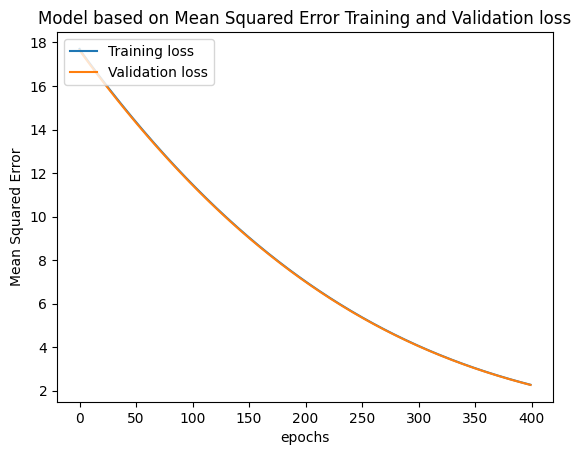

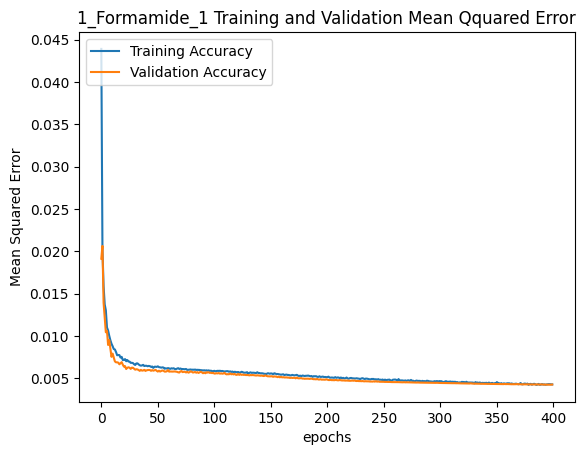

In [17]:
pheno_name='1_Formamide_1'
evaluateModel_loss(history_mse,'Model based on Mean Squared Error','loss','val_loss')
evaluateModel_metric(history_mse,pheno_name,'mse','val_mse')

In [18]:
model_mse.save('saved Models/1_Formamide_1.h5')

14/14 [==============================] - 0s 5ms/step
(1, 419)
count    419.000000
mean       0.535909
std        0.035491
min        0.457517
25%        0.511174
50%        0.534746
75%        0.561304
max        0.630340
Name: 1_Formamide_1, dtype: float64

count    419.000000
mean       0.539605
std        0.073804
min        0.313587
25%        0.493442
50%        0.548007
75%        0.592161
max        0.697673
Name: 1_Formamide_1_actual, dtype: float64


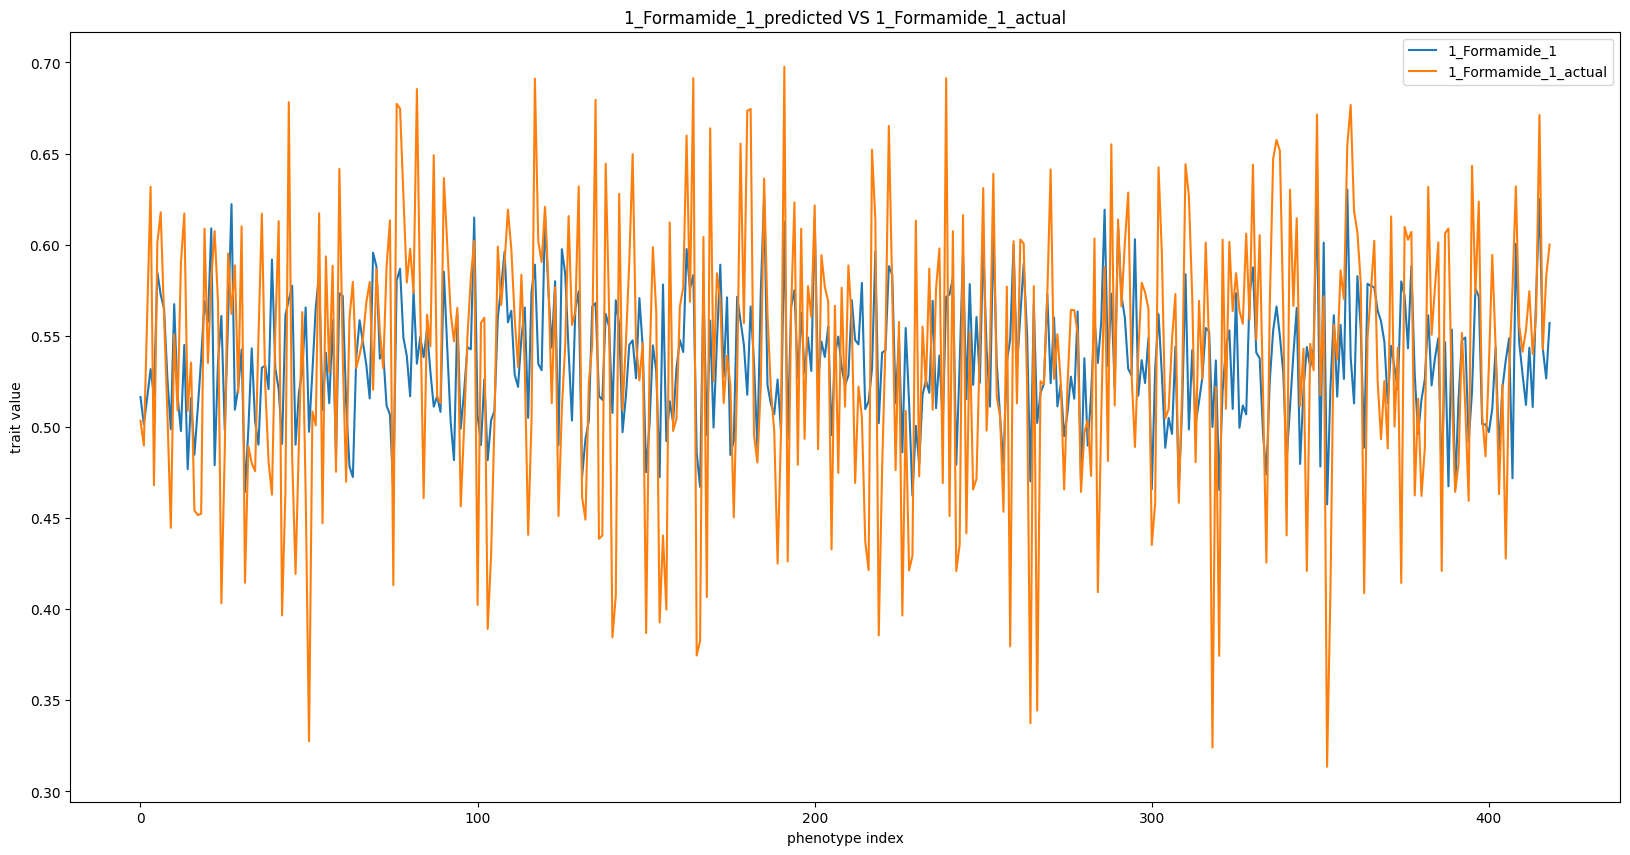

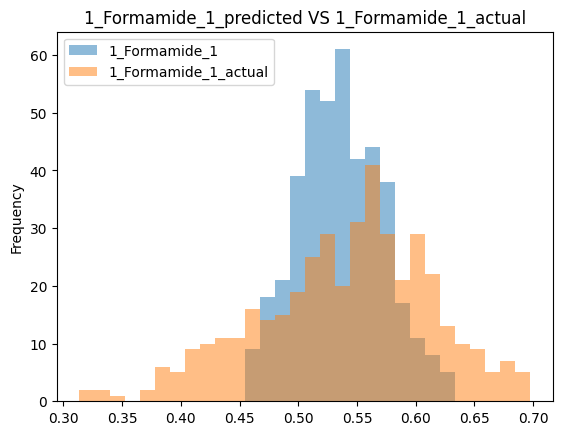

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm.auto import tqdm
import itertools

phenoName = '1_Formamide_1'
phenoIdx = 5
def modelEvals_test_data(phenoName, phenoIdx,model):
    predicted_labels = np.array(model.predict(np.stack(x_test.reshape((x_test.shape[0], 28220,3))))).T
    print(predicted_labels.shape)
    #print(predicted_labels[0,:])
    df = pd.DataFrame(predicted_labels[0,:],columns=[phenoName])
    df[str(phenoName+'_actual')] = y_test[:]
    print(df[phenoName].describe())
    print()
    print(df[str(phenoName+'_actual')].describe())
    
    pred1=df[[phenoName,str(phenoName+'_actual')]]
    pred1.plot.line(figsize=(20,10),title= str(phenoName+'_predicted' +' VS '+str(phenoName+'_actual')),xlabel='phenotype index',ylabel='trait value')
    pred1.plot.hist(bins=30, alpha=0.5, title= str(phenoName+'_predicted' +' VS '+str(phenoName+'_actual')),xlabel='phenotype Value',ylabel='Frequency')
modelEvals_test_data(phenoName, phenoIdx,model_mse)

In [27]:
#load saved model
model_mse = tf.keras.models.load_model('saved Models/1_Formamide_1.h5')
evaluate_data = model_mse.evaluate(
    x_test, y_test, verbose=1, batch_size=32)
#print(evaluate_data)

# predict
predict_data = model_mse.predict(x_test)

/home/rkannan/miniconda3/envs/richard_tf/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


14/14 [==============================] - 0s 5ms/step


In [28]:
#test_pred = {'y_test':y_test.tolist(), 'y_pred': [i[0] for i in predict_data]}

In [31]:
# test_pred_df = pd.DataFrame(test_pred)
# corr_ = test_pred_df['y_test'].corr(test_pred_df['y_pred'])
# print ("Correlation between ", 'y_test', " and ", 'y_pred', "is: ", round(corr_, 2))

Correlation between  y_test  and  y_pred is:  0.61
